# Feature Extraction Using OpenCv

In [38]:
import os
import pandas as pd
import pywt

current_script_path = os.path.abspath("Feature-Extraction.ipynb") 
parent_dir = os.path.dirname(current_script_path)

dataset_path = os.path.join(parent_dir, "..", "Dataset") 

class_image_count = {}

for class_name in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_folder_path):
        num_images = len([
            file for file in os.listdir(class_folder_path)
            if os.path.isfile(os.path.join(class_folder_path, file))
        ])
        class_image_count[class_name] = num_images

df = pd.DataFrame(list(class_image_count.items()), columns=['Class Name', 'Image Count'])

df.index = range(1, len(df) + 1)
df.index.name = "No"
print("Dataset Details \n")
styled_df = df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', '#333'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('background-color', '#fcfcfc'), ('color', '#333')]}
]).set_properties(**{'text-align': 'left'})

styled_df


Dataset Details 



,Class Name,Image Count
No,,
1,Castor,129
2,Catharanthus,134
3,Curry,168
4,Doddpathre,142
5,Mint,135
6,Neem,132
7,Palak(Spinach),149
8,Papaya,135
9,Tamarind,176


In [40]:
total_images = df['Image Count'].sum()
print(f"\nTotal number of images in the dataset: {total_images}")


Total number of images in the dataset: 1477


# Preprocessing

In [43]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 128      
grayscale = False  

X = []  
y = []  
class_names = []  
class_to_index = {}

for idx, class_name in enumerate(sorted(os.listdir(dataset_path))):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        class_names.append(class_name)
        class_to_index[class_name] = idx

        for file in tqdm(os.listdir(class_folder_path), desc=f"Processing {class_name}"):
            file_path = os.path.join(class_folder_path, file)
            
            if os.path.isfile(file_path):
                try:
                    img = cv2.imread(file_path)

                    if img is None:
                        continue 

                    if grayscale:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    
                    img = img / 255.0

                
                    X.append(img)
                    y.append(idx)

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


Processing Tulsi: 100%|██████████████████████████████████████████████████████████████| 177/177 [00:35<00:00,  5.03it/s]


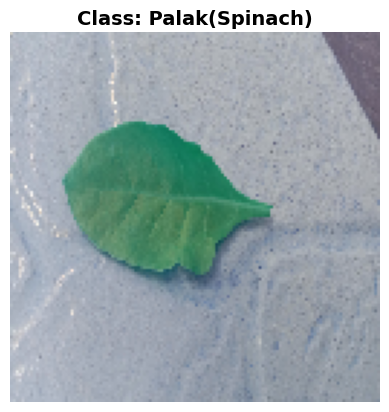

In [149]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(X) - 1)

image = X[random_index]
label_index = y[random_index]
label_name = class_names[label_index]

if grayscale:
    plt.imshow(image, cmap='gray')
else:
    plt.imshow(image)
    
plt.title(f"Class: {label_name}", fontsize=14, fontweight='bold')
plt.axis('off')

plt.show()

In [151]:
grayscale = False

X = []
y = []
class_names = []
class_to_index = {}

lower_green = np.array([25, 40, 40])
upper_green = np.array([85, 255, 255])

for idx, class_name in enumerate(sorted(os.listdir(dataset_path))):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        class_names.append(class_name)
        class_to_index[class_name] = idx

        for file in tqdm(os.listdir(class_folder_path), desc=f"Segmenting {class_name}"):
            file_path = os.path.join(class_folder_path, file)

            if os.path.isfile(file_path):
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        continue

                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    mask = cv2.inRange(hsv, lower_green, upper_green)
                    segmented = cv2.bitwise_and(img, img, mask=mask)

                    if grayscale:
                        segmented = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
                    segmented = segmented / 255.0


                    X.append(segmented)
                    y.append(idx)

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")


Segmenting Tulsi: 100%|██████████████████████████████████████████████████████████████| 177/177 [00:34<00:00,  5.07it/s]


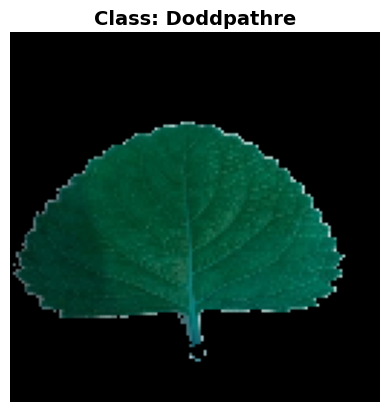

In [181]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(X) - 1)

image = X[random_index]
label_index = y[random_index]
label_name = class_names[label_index]

if grayscale:
    plt.imshow(image, cmap='gray')
else:
    plt.imshow(image)
    
plt.title(f"Class: {label_name}", fontsize=14, fontweight='bold')
plt.axis('off')

plt.show()

# Color Features

In [184]:
features_folder = "Features"
output_csv_name = "color_features.csv"
output_csv_path = os.path.join(features_folder, output_csv_name)

if not os.path.exists(features_folder):
    os.makedirs(features_folder)
    print(f" Created folder: {features_folder}")

features = []

for class_name in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        print(f"\n Extracting features for class: {class_name}")
        
        for file_name in tqdm(os.listdir(class_folder_path), desc=f"Processing images in '{class_name}'"):
            file_path = os.path.join(class_folder_path, file_name)

            if os.path.isfile(file_path):
                try:

                    img = cv2.imread(file_path)
                    if img is None:
                        continue

                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    
                    b, g, r = cv2.split(img)

                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    h, s, v = cv2.split(hsv)

                    mean_r = np.mean(r)
                    mean_g = np.mean(g)
                    mean_b = np.mean(b)

                    std_r = np.std(r)
                    std_g = np.std(g)
                    std_b = np.std(b)

                    mean_h = np.mean(h)
                    mean_s = np.mean(s)
                    mean_v = np.mean(v)

                    features.append([
                        mean_r, mean_g, mean_b,
                        std_r, std_g, std_b,
                        mean_h, mean_s, mean_v,
                        class_name
                    ])

                except Exception as e:
                    print(f" Error processing {file_path}: {e}")

columns = [
    'mean_red', 'mean_green', 'mean_blue',
    'std_red', 'std_green', 'std_blue',
    'mean_hue', 'mean_saturation', 'mean_value',
    'class_label'
]

df = pd.DataFrame(features, columns=columns)

df.to_csv(output_csv_path, index=False)
print(f"\n Feature extraction completed and saved to: {output_csv_path}")


 Extracting features for class: Castor


Processing images in 'Castor': 100%|████████████████████████████████████████████████| 129/129 [00:00<00:00, 153.16it/s]



 Extracting features for class: Catharanthus


Processing images in 'Catharanthus': 100%|██████████████████████████████████████████| 134/134 [00:00<00:00, 170.81it/s]



 Extracting features for class: Curry


Processing images in 'Curry': 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 159.06it/s]



 Extracting features for class: Doddpathre


Processing images in 'Doddpathre': 100%|████████████████████████████████████████████| 142/142 [00:00<00:00, 154.71it/s]



 Extracting features for class: Mint


Processing images in 'Mint': 100%|██████████████████████████████████████████████████| 135/135 [00:00<00:00, 153.48it/s]



 Extracting features for class: Neem


Processing images in 'Neem': 100%|██████████████████████████████████████████████████| 132/132 [00:00<00:00, 159.66it/s]



 Extracting features for class: Palak(Spinach)


Processing images in 'Palak(Spinach)': 100%|█████████████████████████████████████████| 149/149 [00:30<00:00,  4.94it/s]



 Extracting features for class: Papaya


Processing images in 'Papaya': 100%|█████████████████████████████████████████████████| 135/135 [00:27<00:00,  4.99it/s]



 Extracting features for class: Tamarind


Processing images in 'Tamarind': 100%|███████████████████████████████████████████████| 176/176 [00:48<00:00,  3.63it/s]



 Extracting features for class: Tulsi


Processing images in 'Tulsi': 100%|██████████████████████████████████████████████████| 177/177 [00:34<00:00,  5.08it/s]


 Feature extraction completed and saved to: Features\color_features.csv


# Shape features

In [187]:
output_csv_name = "shape_features.csv"
output_csv_path = os.path.join(features_folder, output_csv_name)

shape_features = []

for class_name in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        print(f"\n Extracting shape features for class: {class_name}")
        
        for file_name in tqdm(os.listdir(class_folder_path), desc=f"Processing {class_name}"):
            file_path = os.path.join(class_folder_path, file_name)

            if os.path.isfile(file_path):
                try:
    
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    
                    
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                    
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if not contours:
                        continue
                    contour = max(contours, key=cv2.contourArea)

                    area = cv2.contourArea(contour)
                    perimeter = cv2.arcLength(contour, True)
                    aspect_ratio = 0
                    circularity = 0

                    x, y, w, h = cv2.boundingRect(contour)
                    if h != 0:
                        aspect_ratio = float(w) / h

                    if perimeter != 0:
                        circularity = (4 * np.pi * area) / (perimeter ** 2)

                    contour_points_count = len(contour)
                    
                    shape_features.append([
                        area,
                        perimeter,
                        aspect_ratio,
                        contour_points_count,
                        circularity,
                        class_name
                    ])

                except Exception as e:
                    print(f" Error processing {file_path}: {e}")

columns = [
    'area', 'perimeter', 'aspect_ratio',
    'contour_points_count', 'circularity', 'class_label'
]

df = pd.DataFrame(shape_features, columns=columns)

df.to_csv(output_csv_path, index=False)
print(f"\n Shape feature extraction completed and saved to: {output_csv_path}")


 Extracting shape features for class: Castor


Processing Castor: 100%|████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 214.05it/s]



 Extracting shape features for class: Catharanthus


Processing Catharanthus: 100%|██████████████████████████████████████████████████████| 134/134 [00:00<00:00, 251.59it/s]



 Extracting shape features for class: Curry


Processing Curry: 100%|█████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 227.79it/s]



 Extracting shape features for class: Doddpathre


Processing Doddpathre: 100%|████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 224.05it/s]



 Extracting shape features for class: Mint


Processing Mint: 100%|██████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 230.87it/s]



 Extracting shape features for class: Neem


Processing Neem: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 193.94it/s]



 Extracting shape features for class: Palak(Spinach)


Processing Palak(Spinach): 100%|█████████████████████████████████████████████████████| 149/149 [00:19<00:00,  7.62it/s]



 Extracting shape features for class: Papaya


Processing Papaya: 100%|█████████████████████████████████████████████████████████████| 135/135 [00:16<00:00,  8.25it/s]



 Extracting shape features for class: Tamarind


Processing Tamarind: 100%|███████████████████████████████████████████████████████████| 176/176 [00:31<00:00,  5.57it/s]



 Extracting shape features for class: Tulsi


Processing Tulsi: 100%|██████████████████████████████████████████████████████████████| 177/177 [00:21<00:00,  8.32it/s]


 Shape feature extraction completed and saved to: Features\shape_features.csv


# Texture Features

In [202]:
import pywt
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor
from skimage import img_as_ubyte
from scipy.stats import entropy

output_csv_name = "texture_features.csv"
output_csv_path = os.path.join(features_folder, output_csv_name)

LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

GLCM_DISTANCES = [1]
GLCM_ANGLES = [0]

texture_features = []

for class_name in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        print(f"\n Extracting texture features for class: {class_name}")
        
        for file_name in tqdm(os.listdir(class_folder_path), desc=f"Processing {class_name}"):
            file_path = os.path.join(class_folder_path, file_name)

            if os.path.isfile(file_path):
                try:
            
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue

                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img_uint8 = img_as_ubyte(img)


                    glcm = graycomatrix(img_uint8, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=256, symmetric=True, normed=True)
                    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
                    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
                    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

                
                    hist = cv2.calcHist([img_uint8], [0], None, [256], [0, 256])
                    hist = hist.ravel() / hist.sum()
                    texture_entropy = entropy(hist, base=2)

                
                    lbp = local_binary_pattern(img_uint8, P=LBP_POINTS, R=LBP_RADIUS, method=LBP_METHOD)
                    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
                    hist_lbp = hist_lbp.astype("float")
                    hist_lbp /= (hist_lbp.sum() + 1e-6)
                    lbp_histogram_mean = hist_lbp.mean()

                
                    gabor_response, _ = gabor(img_uint8, frequency=0.6)
                    gabor_mean_response = gabor_response.mean()

                
                    coeffs = pywt.dwt2(img_uint8, 'db1')
                    _, (cH, cV, cD) = coeffs
                    dwt_energy = np.sum(cH ** 2) + np.sum(cV ** 2) + np.sum(cD ** 2)
                    
                    texture_features.append([
                        glcm_contrast,
                        glcm_correlation,
                        glcm_homogeneity,
                        texture_entropy,
                        lbp_histogram_mean,
                        gabor_mean_response,
                        dwt_energy,
                        class_name
                    ])

                except Exception as e:
                    print(f" Error processing {file_path}: {e}")
                    
columns = [
    'glcm_contrast', 'glcm_correlation', 'glcm_homogeneity',
    'texture_entropy', 'lbp_histogram_mean', 'gabor_mean_response',
    'dwt_texture_energy', 'class_label'
]

df = pd.DataFrame(texture_features, columns=columns)
df.to_csv(output_csv_path, index=False)
print(f"\n  Texture feature extraction completed and saved to: {output_csv_path}")


 Extracting texture features for class: Castor


Processing Castor: 100%|█████████████████████████████████████████████████████████████| 129/129 [00:02<00:00, 48.09it/s]



 Extracting texture features for class: Catharanthus


Processing Catharanthus: 100%|███████████████████████████████████████████████████████| 134/134 [00:02<00:00, 50.51it/s]



 Extracting texture features for class: Curry


Processing Curry: 100%|██████████████████████████████████████████████████████████████| 168/168 [00:03<00:00, 50.12it/s]



 Extracting texture features for class: Doddpathre


Processing Doddpathre: 100%|█████████████████████████████████████████████████████████| 142/142 [00:02<00:00, 49.59it/s]



 Extracting texture features for class: Mint


Processing Mint: 100%|███████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 50.23it/s]



 Extracting texture features for class: Neem


Processing Neem: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:02<00:00, 47.50it/s]



 Extracting texture features for class: Palak(Spinach)


Processing Palak(Spinach): 100%|█████████████████████████████████████████████████████| 149/149 [00:22<00:00,  6.71it/s]



 Extracting texture features for class: Papaya


Processing Papaya: 100%|█████████████████████████████████████████████████████████████| 135/135 [00:19<00:00,  7.10it/s]



 Extracting texture features for class: Tamarind


Processing Tamarind: 100%|███████████████████████████████████████████████████████████| 176/176 [00:34<00:00,  5.10it/s]



 Extracting texture features for class: Tulsi


Processing Tulsi: 100%|██████████████████████████████████████████████████████████████| 177/177 [00:24<00:00,  7.34it/s]


  Texture feature extraction completed and saved to: Features\texture_features.csv


# Edge Features

In [205]:
output_csv_name = "edge_features.csv"
output_csv_path = os.path.join(features_folder, output_csv_name)

edge_features = []

for class_name in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder_path):
        print(f"\n Extracting edge features for class: {class_name}")
        
        for file_name in tqdm(os.listdir(class_folder_path), desc=f"Processing {class_name}"):
            file_path = os.path.join(class_folder_path, file_name)

            if os.path.isfile(file_path):
                try:
                
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        
                    canny_edges = cv2.Canny(img, 100, 200)
                    canny_edge_count = np.sum(canny_edges > 0)
                    edge_pixel_ratio = canny_edge_count / (IMG_SIZE * IMG_SIZE)

                
                    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
                    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
                    sobel_gradient = np.sqrt(sobel_x**2 + sobel_y**2)
                    sobel_gradient_mean = np.mean(sobel_gradient)
                    sobel_gradient_std = np.std(sobel_gradient)

                    
                    laplacian = cv2.Laplacian(img, cv2.CV_64F)
                    laplacian_variance = laplacian.var()

 
                    edge_features.append([
                        canny_edge_count,
                        edge_pixel_ratio,
                        sobel_gradient_mean,
                        sobel_gradient_std,
                        laplacian_variance,
                        class_name
                    ])

                except Exception as e:
                    print(f" Error processing {file_path}: {e}")

columns = [
    'canny_edge_count', 'edge_pixel_ratio',
    'sobel_gradient_mean', 'sobel_gradient_std',
    'laplacian_variance', 'class_label'
]

df = pd.DataFrame(edge_features, columns=columns)
df.to_csv(output_csv_path, index=False)
print(f"\n Edge feature extraction completed and saved to: {output_csv_path}")


 Extracting edge features for class: Castor


Processing Castor: 100%|████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 158.33it/s]



 Extracting edge features for class: Catharanthus


Processing Catharanthus: 100%|██████████████████████████████████████████████████████| 134/134 [00:00<00:00, 166.64it/s]



 Extracting edge features for class: Curry


Processing Curry: 100%|█████████████████████████████████████████████████████████████| 168/168 [00:01<00:00, 167.91it/s]



 Extracting edge features for class: Doddpathre


Processing Doddpathre: 100%|████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 155.97it/s]



 Extracting edge features for class: Mint


Processing Mint: 100%|██████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 171.66it/s]



 Extracting edge features for class: Neem


Processing Neem: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 149.57it/s]



 Extracting edge features for class: Palak(Spinach)


Processing Palak(Spinach): 100%|█████████████████████████████████████████████████████| 149/149 [00:20<00:00,  7.44it/s]



 Extracting edge features for class: Papaya


Processing Papaya: 100%|█████████████████████████████████████████████████████████████| 135/135 [00:17<00:00,  7.62it/s]



 Extracting edge features for class: Tamarind


Processing Tamarind: 100%|███████████████████████████████████████████████████████████| 176/176 [00:31<00:00,  5.60it/s]



 Extracting edge features for class: Tulsi


Processing Tulsi: 100%|██████████████████████████████████████████████████████████████| 177/177 [00:21<00:00,  8.41it/s]


 Edge feature extraction completed and saved to: Features\edge_features.csv
